## LSTM Classification with FastText Embeddings

In [27]:
import os 
import numpy as np 
import re 
import pickle
import pandas as pd
import operator 
from functools import reduce
from tqdm import tqdm
import string

from nltk.tokenize import word_tokenize

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU

from gensim.models import FastText

from matplotlib import pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')

DATA_DIR = "../../../data/datasets/merged_files"
FAST_TEXT_DATA_DIR = "../../../helper/data_obtaining/science_direct/out/merged_datasets/"
N_SAMPLES_FAST_TEXT = 10000

In [2]:
def preprocess_raw_data(doc: str) -> list:
    doc = nlp(doc)
    return [[x.lower_ for x in text if x.is_alpha and not x.is_punct] for text in doc.sents]

In [3]:
def load_lstm_data(directory: str):
    data_raw, labels = list(), list()
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            data_raw.append(open(os.path.join(directory, file), "r").read())
            labels.append(file.split(".")[0])
    return data_raw, labels

In [4]:
def load_fasttext_data(directory: str):
    raw_out = list()
    for sub in os.listdir(directory):
        if os.path.isdir(directory+sub):
            for file in [x for x in os.listdir(directory+sub) if x.endswith(".txt")]:
                raw_out.append(open(directory+sub+"/"+file, "r").read().replace("  ", " "))
    return raw_out

### Loading data for FastText model
__Data cleaning:__<br/>
- Removing of punctuation and nums with re '[a-z]+'
- Result: List of word tokenized sentences (List(List(String))

In [5]:
"""
ft_data = list()
for doc in tqdm(shuffle(ft_data_raw)[:10000]): 
    preprocessed_doc = preprocess_raw_data(doc)
    ft_data.extend(preprocessed_doc)
ft_data[0]
"""
# Literally takes forever > Check without preprocessing again

if os.path.exists("fastText_data_{}.pkl".format(N_SAMPLES_FAST_TEXT)):
    ft_data = pickle.load(open("fastText_data_{}.pkl".format(N_SAMPLES_FAST_TEXT), "rb"))
else:
    ft_data_raw = load_fasttext_data(FAST_TEXT_DATA_DIR)
    ft_data = list()
    for doc in tqdm(shuffle(ft_data_raw)[:N_SAMPLES_FAST_TEXT]):
        sents = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', doc)
        for s in sents:
            tokens = word_tokenize(s)
            clean = [t.lower() for t in tokens if re.match("[a-z]+", t.lower()) is not None]
            ft_data.append(clean)
    pickle.dump(ft_data, open("fastText_data_{}.pkl".format(N_SAMPLES_FAST_TEXT), "wb"))
print(ft_data[0])

['abstract', 'self-care', 'problems', 'diagnosis', 'and', 'classification', 'is', 'an', 'important', 'challenge', 'in', 'exceptional', 'children', 'health', 'care', 'systems']


### Loading data for LSTM

In [6]:
raw, raw_labels = load_lstm_data(DATA_DIR)
data = list()
for text in raw:
    data.append(preprocess_raw_data(text))

In [7]:
print("______DATA FORMAT______")
print("data: List(List(String))")
print("labels: List(String)")
print("Classes: {}".format(len(data)))
print("Class distribution: {} {} - {} {} - {} {}".format(raw_labels[0], len(data[0]), 
                                                         raw_labels[1], len(data[1]), 
                                                         raw_labels[2], len(data[2])))
print("__________________________________")

______DATA FORMAT______
data: List(List(String))
labels: List(String)
Classes: 3
Class distribution: prediction 2364 - clustering 2619 - frequent_pattern_mining 546
__________________________________


### Train a FastText model to derive Word Embeddings

In [8]:
if os.path.exists("ft_model_{}.pkl".format(N_SAMPLES_FAST_TEXT)):
    ft_model = pickle.load(open("ft_model_{}.pkl".format(N_SAMPLES_FAST_TEXT), "rb"))
else:
    ft_model = FastText(ft_data, size=100, window=5, min_count=5, workers=3, sg=1)
    pickle.dump(ft_model, open("ft_model_{}.pkl".format(N_SAMPLES_FAST_TEXT), "wb"))

#### Quick check on functionality and quality of embeddings

In [9]:
ft_model.wv.most_similar("Clustering")

/Users/richardhorn/anaconda3/envs/rs/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('coclustering', 0.9364023208618164),
 ('swclustering', 0.9258905053138733),
 ('lrclustering', 0.9215612411499023),
 ('clustering', 0.9189531803131104),
 ('prankclustering', 0.911766529083252),
 ('reclustering', 0.9081591367721558),
 ('biclustering', 0.9043294191360474),
 ('preclustering', 0.9026942253112793),
 ('bi-clustering', 0.9004812240600586),
 ('declustering', 0.8991345167160034)]

In [10]:
ft_model.wv.most_similar("Regression")

[('logicregression', 0.8992341756820679),
 ('meta-regression', 0.8912472724914551),
 ('regression', 0.876956582069397),
 ('c-regression', 0.8653339147567749),
 ('regression/correlation', 0.8650035858154297),
 ('regression-lai', 0.8632293939590454),
 ('gression', 0.8632272481918335),
 ('regressions', 0.8619264960289001),
 ('regression-kriging', 0.8538936376571655),
 ('agression', 0.8441092371940613)]

In [11]:
ft_model.wv.similarity("clustering", "regression")

0.41599146

### Prepare data for LSTM

In [12]:
def derive_sentence_vector(sent):
    vectors = []
    for token in sent:
        if ft_model.wv.__contains__(token):
            vectors.append(ft_model.wv.__getitem__(token))
    return sum(vectors)/len(vectors)

In [13]:
df_data = pd.DataFrame(columns=["label", "clear label", "text", "vector"])
for i, (cl, l) in enumerate(zip(data, raw_labels)):
    for sent in cl:
        if len(sent) > 0:
            temp_df = pd.DataFrame([[i, l, sent, derive_sentence_vector(sent)]], 
                                   columns=["label", "clear label", "text", "vector"])
            df_data = df_data.append(temp_df, ignore_index=True)

df_data = shuffle(df_data).reset_index()
df_data.loc[:9]

,index,label,clear label,text,vector
0,601,0,prediction,"[classification, is, a, very, important, field...","[0.19949676, 0.22450398, -0.3021901, 0.1023725..."
1,2758,1,clustering,"[clustering, is, a, common, technique, for, st...","[0.14455421, 0.16508643, -0.22018084, 0.092961..."
2,2358,1,clustering,"[the, reviewed, literature, leads, to, the, fo...","[0.13997078, 0.23241495, -0.2627896, -0.047451..."
3,3248,1,clustering,"[hence, we, see, successful, application, of, ...","[0.19287322, 0.24820286, -0.2766688, 0.0174228..."
4,4752,1,clustering,"[compared, with, supervised, learning, cluster...","[0.11539412, 0.2564255, -0.3025535, 0.13784078..."
5,2670,1,clustering,"[however, it, is, not, fully, understood, whet...","[0.12868866, 0.25812417, -0.27068955, -0.07421..."
6,569,0,prediction,"[it, can, be, seen, that, if, the, classifier,...","[0.16009589, 0.25442773, -0.2903351, -0.040104..."
7,232,0,prediction,"[projection, pursuit, regression, projection, ...","[0.2829726, -0.004418063, -0.471544, 0.1178580..."
8,2109,0,prediction,"[when, the, training, algorithm, tries, to, fi...","[0.10802021, 0.28760976, -0.35611635, 0.006912..."
9,5117,2,frequent_pattern_mining,"[however, the, downwardclosure, property, in, ...","[0.1947148, 0.20444857, -0.2517771, 0.01829162..."


In [14]:
features = list(df_data['vector'])
labels = list(df_data['label'])

In [15]:
X_train, X_test, y_train, y_test, _, _ = train_test_split(features, labels, df_data.index, test_size=0.20, random_state=0)

In [16]:
print(type(X_train))
print(len(X_train))
print(type(y_train))
print(len(y_train))
print(np.array(X_train).reshape(len(X_train), 1, 100).shape)

<class 'list'>
4400
<class 'list'>
4400
(4400, 1, 100)


### Define and Train LSTM Model
Input to LSTM has shape (n_samples, n_timesteps, n_features)

In [28]:
lstm = Sequential()
lstm.add(GRU(units=200, input_shape = (None, 100), return_sequences = True))
# lstm.add(Dropout(0.2))
# lstm.add(LSTM(units=100, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='relu'))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 200)         180600    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           201       
Total params: 180,801
Trainable params: 180,801
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
lstm_history = lstm.fit(np.array(X_train).reshape(len(X_train), 1, 100), 
                        np.array(y_train).reshape(len(y_train), 1, 1), 
                        epochs=20, 
                        batch_size=128)

Epoch 1/20
4400/4400 [==============================] - 1s 268us/step - loss: 0.4152 - acc: 0.5475
Epoch 2/20
4400/4400 [==============================] - 0s 60us/step - loss: 0.2042 - acc: 0.7686
Epoch 3/20
4400/4400 [==============================] - 0s 65us/step - loss: 0.1349 - acc: 0.8573
Epoch 4/20
4400/4400 [==============================] - 0s 67us/step - loss: 0.1201 - acc: 0.8741
Epoch 5/20
4400/4400 [==============================] - 0s 71us/step - loss: 0.1147 - acc: 0.8830
Epoch 6/20
4400/4400 [==============================] - 0s 76us/step - loss: 0.1123 - acc: 0.8811
Epoch 7/20
4400/4400 [==============================] - 0s 66us/step - loss: 0.1083 - acc: 0.8855
Epoch 8/20
4400/4400 [==============================] - 0s 65us/step - loss: 0.1060 - acc: 0.8845
Epoch 9/20
4400/4400 [==============================] - 0s 66us/step - loss: 0.1040 - acc: 0.8877
Epoch 10/20
4400/4400 [==============================] - 0s 75us/step - loss: 0.1058 - acc: 0.8852
Epoch 11/20
4400/4

#### Evaluate trained LSTM Model

In [30]:
# Final evaluation of the model
scores = lstm.evaluate(np.array(X_test).reshape(len(X_test), 1, 100), 
                       np.array(y_test).reshape(len(y_test), 1, 1), 
                       verbose=10)
print("Accuracy: {}%".format((scores[1]*100)))

Accuracy: 90.73569483371566%


In [31]:
print(lstm_history.history.keys())

dict_keys(['loss', 'acc'])


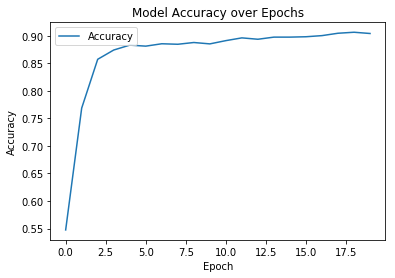

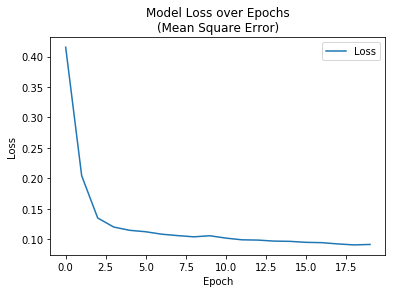

In [32]:
plt.plot(lstm_history.history['acc'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Accuracy"], loc='upper left')
plt.show()

plt.plot(lstm_history.history['loss'])
plt.title('Model Loss over Epochs\n(Mean Square Error)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Loss"], loc='upper right')
plt.show()

### Make prediction on problem statement

In [33]:
def load_valid_data():
    texts = open("valid.txt", "r").read().split("\n")
    v_labels, v_text = list(), list()
    for text in texts: 
        label, txt = text.split("_")
        v_labels.append(label)
        v_text.append(txt)
    return v_labels, v_text

In [34]:
def transform_input(text):
    data = preprocess_raw_data(text)
    res = list()
    for s in data:
        x = derive_sentence_vector(s)
        res.append(x)
    return np.array(res).reshape(len(res), 1, 100)

In [35]:
v_labels, v_inputs = load_valid_data()
for l, t in zip(v_labels, v_inputs):
    print(t)
    x = transform_input(t)
    y = lstm.predict_classes(x, verbose=10)
    for pred in y:
        print("Predicted: {} - {} | Ground truth: {}".format(pred[0][0], raw_labels[pred[0][0]], l))
    print("____________")

I have different machine types and want to find similar error structures based on recent error history. Thereby, the error should be grouped in different categories or groups which are as dissimilar as possible.
Predicted: 0 - prediction | Ground truth: clustering
Predicted: 0 - prediction | Ground truth: clustering
____________
In terms of a new product introduction, the price of a product should be predicted based on different characteristics like the size, equipment features or the buying power of the area.
Predicted: 0 - prediction | Ground truth: prediction
____________
The analysis should evauate the relationship between the weather and the amount of sold ice cream. More specific, it should be examined how much the temperature influences the renvenue of the organization.
Predicted: 1 - clustering | Ground truth: prediction
Predicted: 1 - clustering | Ground truth: prediction
____________
Clustering is unsupervised and helps grouping similar objects.
Predicted: 1 - clustering | Gr